# Status of COVID19

We use data from the files at https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

Thank you @CSSEGISandData for providing the data!

In [1]:
%config InlineBackend.figure_formats = ['svg']
import math
from numpy import log, exp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd
#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

import numpy as np
#figsize = 11, 5
LW = 3

base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

def double_time_exponential(q2_div_q1, t2_minus_t1=None):
    """ See https://en.wikipedia.org/wiki/Doubling_time"""
    # print(f"double_time_exponential: {q2_div_q1}, {t2_minus_t1} ")
    if t2_minus_t1 is None:
        t2_minus_t1 = np.ones(q2_div_q1.shape)
        # print(f"shape t: {t2_minus_t1.shape}, shape q: {q2_div_q1.shape}")
        # print(f"type t: {type(t2_minus_t1)}, type q: {type(q2_div_q1.shape)}")
    return t2_minus_t1 * np.log(2) / np.log(q2_div_q1) 

def string_to_date(input_):
    """Converts string of type 01/22/02 [for 22 Jan 2020] into datetime object"""
    # return pd.to_datetime(input_, format='%m/%d/%y', errors='ignore')
    return pd.to_datetime(input_, format='%m/%d/%y')
    
def fetch_deaths():
    url = os.path.join(base_url, "time_series_covid19_" + "deaths" + "_global.csv")
    df = pd.read_csv(url, index_col=1)
    return df

def fetch_cases():
    url = os.path.join(base_url, "time_series_covid19_" + "confirmed" + "_global.csv")
    df = pd.read_csv(url, index_col=1)
    return df

deaths = fetch_deaths()
cases = fetch_cases()


In [2]:
def get_country(country):
    """Given a country name, return deaths and cases as time series.
    All rows should contain a datetime index and a value"""
    assert country in deaths.index, f"{country} not in available countries. These are {sorted(deaths.index)}"
    
    # Some countries need special data cleaning:
    if country in ["China", "France"]:
        d = deaths.loc[country].sum()
        c = cases.loc[country].sum()
    else:
        d = deaths.loc[country]
        c = cases.loc[country]

    # make date string into timeindex
    d.index = pd.to_datetime(d.index, errors="coerce", format="%m/%d/%y")
    c.index = pd.to_datetime(c.index, errors="coerce", format="%m/%d/%y")
    # drop all rows that don't have data
    # sanity check: how many do we drop?
    if c.index.isnull().sum() > 3:
        print(f"about to drop {c.index.isnull().sum()} entries due to NaT in index", c)
    c = c[c.index.notnull()] 

    if d.index.isnull().sum() > 3:
        print(f"about to drop {d.index.isnull().sum()} entries due to NaT in index", d)
    d = d[d.index.notnull()] 
    
    # check there are no NaN is in the data
    assert c.isnull().sum() == 0, f"{c.isnull().sum()} NaNs in {c}"
    assert d.isnull().sum() == 0, f"{d.isnull().sum()} NaNs in {d}"
    
    # label data
    c.country = country
    c.label = "cases"
    
    d.country = country
    d.label = "deaths"
    
    return c, d

In [3]:
def plot_time_step(ax, series, style="-", logscale=True):
    ax.step(series.index, series.values, style, label=series.country + " " + series.label,
           linewidth=LW)
    if logscale:
        ax.set_yscale('log')
    ax.legend()
    ax.set_ylabel("total numbers")
    return ax

def plot_change_bar(ax, series, color, rolling=None):
    change = series.diff().dropna()   # lose one point at beginning

    if rolling:
        rolling_label = f" {rolling}-day rolling mean"
        rolling_series = change.rolling(rolling, center=True).mean()
        bar_alpha = 0.2
    else:
        rolling_label = ""
        bar_alpha = 1.0

    label = series.country + " new " + series.label 
    ax.bar(change.index, change.values, color=color, label=label, alpha=bar_alpha, 
           linewidth=LW)
    if rolling:
        ax.plot(rolling_series.index, rolling_series.values, color=color, label=label + rolling_label,
                linewidth=LW)
    ax.legend()
    ax.set_ylabel('daily change')
    return ax

def plot_doubling_time(ax, series, color):
    # only keep values where there is a change of => 10
    #sel = c.diff() <= 10
    #series.drop(c[sel].index, inplace=True)
    
    # we assume we have one value for every day - should check XXX
    q2_div_q1 = series.pct_change() + 1  # computes q2/q1
    q2_div_q1.replace(np.inf, np.nan, inplace=True)  # get rid of x/0 results
    q2_div_q1.dropna(inplace=True)
    dtime = double_time_exponential(q2_div_q1, t2_minus_t1=1)
    dtime.dropna(inplace=True)
    label = series.country + " new " + series.label 
    ax.plot(dtime.index, dtime.values, 'o', color=color, alpha=0.3, label=label)
    
    # need rolling average to smooth out weekly variations
    rolling = dtime.rolling(7, center=True).mean()
    # good to take maximum value from here
    ymax = min(rolling.max()*1.5, 500)
    ax.set_ylim(0, ymax)
    ax.plot(dtime.index, rolling, "-", color=color, alpha=1.0, label=label + ' 7-day rolling mean',
            linewidth=LW)
    ax.legend()
    ax.set_ylabel("doubling time [days]")
    return ax

In [4]:
def overview(country):
    c, d = get_country(country)

    fig, axes = plt.subplots(4, 1, figsize=(8, 16))
    ax = axes[0]
    plot_time_step(ax=ax, series=c, style="-C1")
    plot_time_step(ax=ax, series=d, style="-C0")

    ax = axes[1]
    plot_change_bar(ax=ax, series=c, rolling=7, color="C1")
    #ax.plot(c.index, c.values, 'o', label="X")
    #plot_change_bar(ax=ax, series=d)

    ax = axes[2]
    plot_change_bar(ax=ax, series=d, rolling=7, color="C0")

    ax = axes[3]
    plot_doubling_time(ax, series=d, color="C0")
    plot_doubling_time(ax, series=c, color="C1")
    
    return axes, c, d




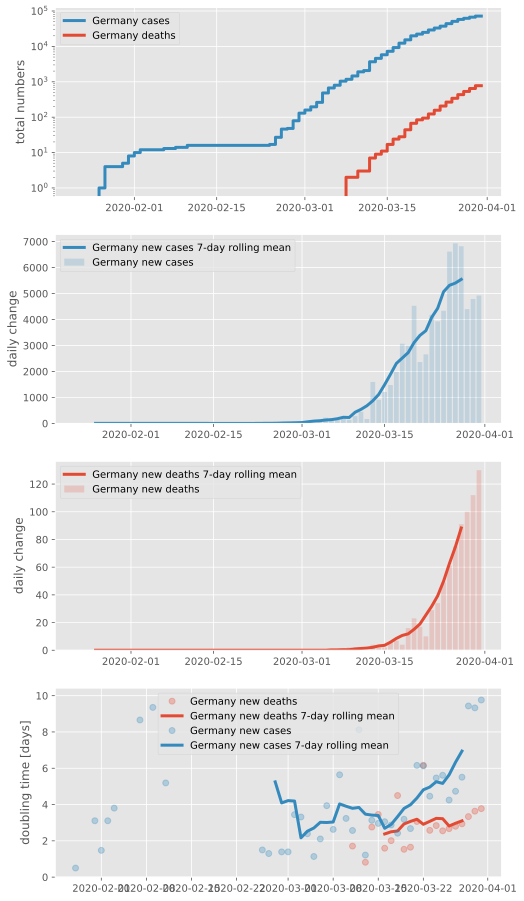

In [5]:
overview("Germany");

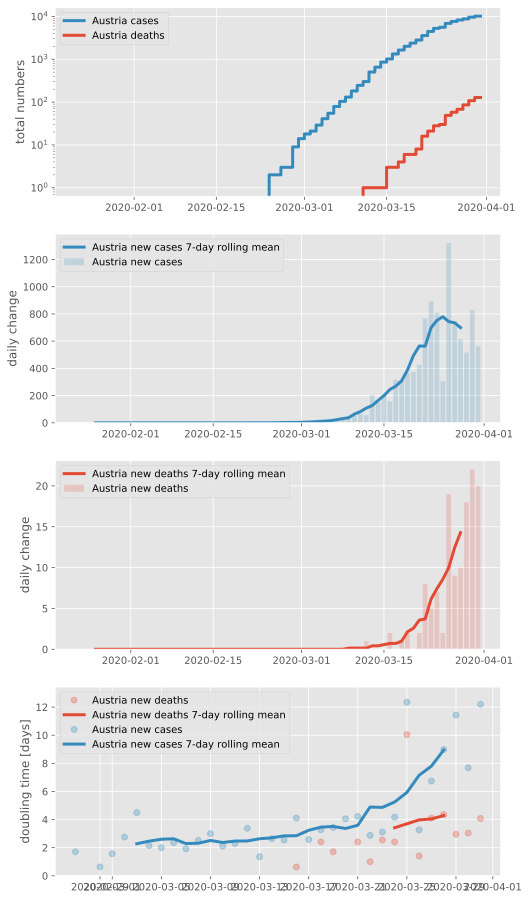

In [6]:
overview("Austria");

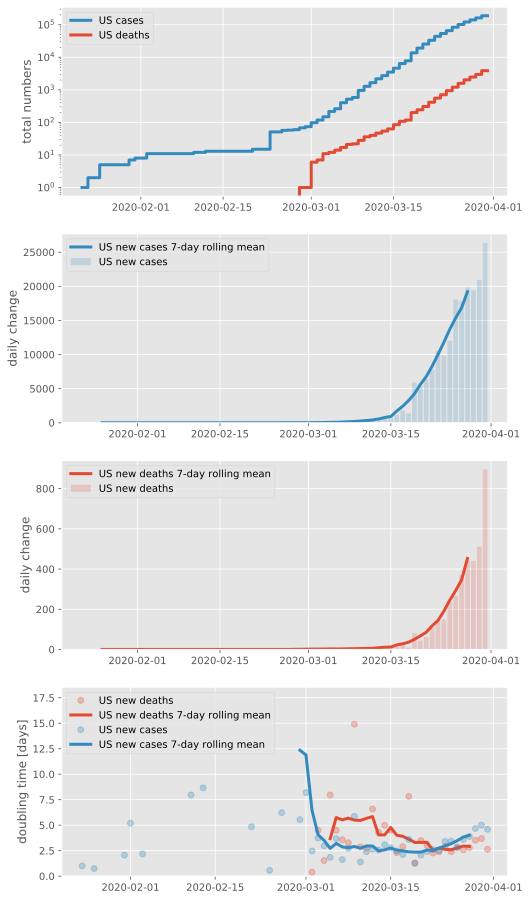

In [7]:
overview("US");

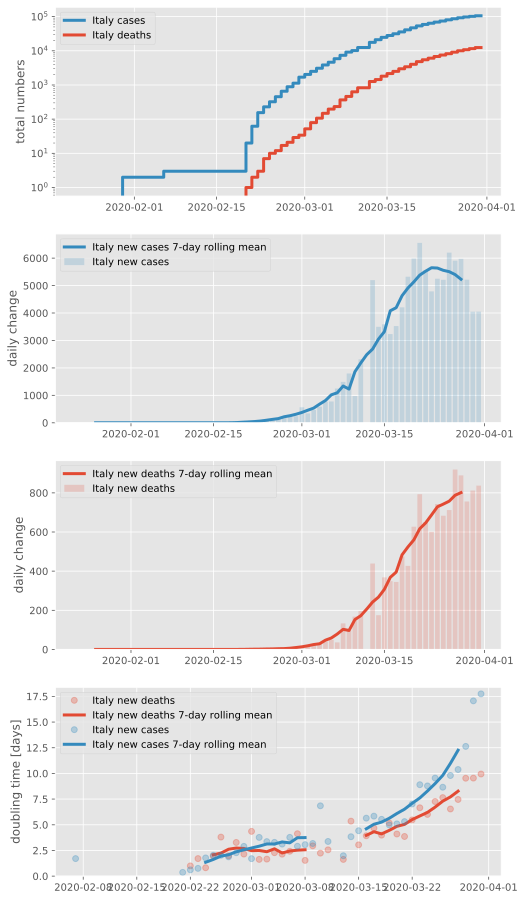

In [8]:
overview("Italy");

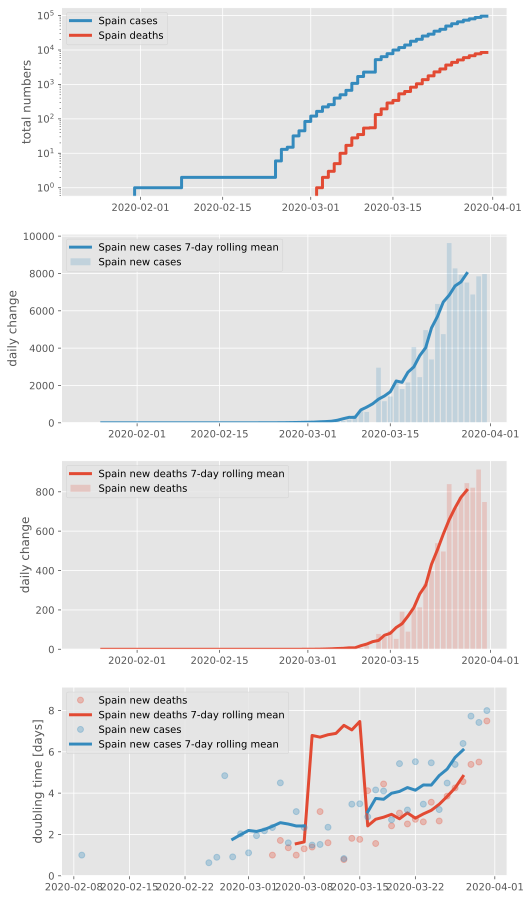

In [9]:
overview("Spain");

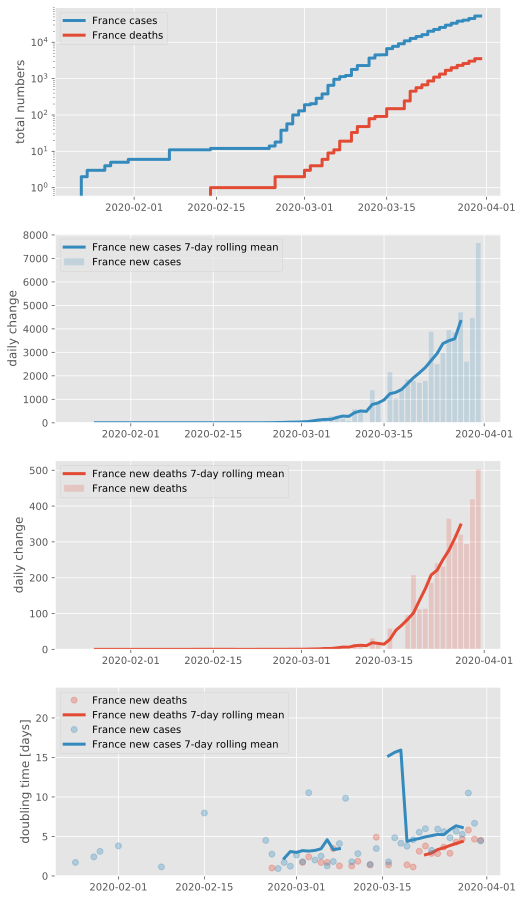

In [10]:
overview("France");

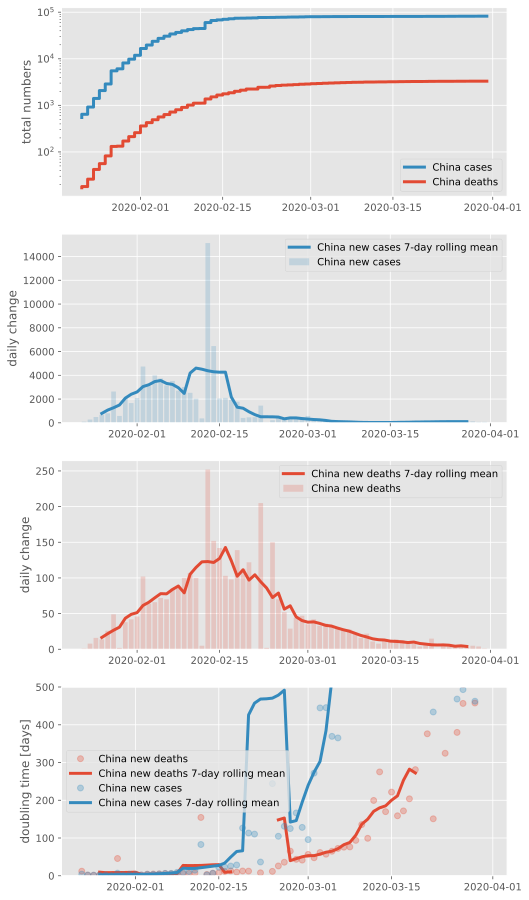

In [11]:
overview("China");